# Inspecting and evalutating the generative ability of our deep AutoEncoder model using OLGA

We investigate how our deep AutoEncoder model could generate new TCR sequences. We evaluate this generative ability by using OLGA and producing probabilities of generation.

In [1]:
# Import all the necessary modules and functions from automate.py
from automate import *

2023-06-10 19:10:22.680524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load dataset
with (open("df_comparison.pkl", "rb")) as openfile:
    df = pickle.load(openfile)

with (open("data.pkl", "rb")) as openfile:
    data = pickle.load(openfile)

data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(54))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(13))
data['CDR3_al_one_hot'] = df['CDR3_al_integer']
data = [np.stack(col.values) for _, col in data.items()]
X_train = data

In [8]:
# Setting the parameters for model building and training of the deep AE
params = {
            "latent_dim": 20,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": 54,
            "j_gene_embedding_dim": 13,
            "beta": 0.2,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": 54,
            "n_j_genes": 13,
            "stopping_monitor": "val_loss",
            "batch_size": 100,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 10,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cdr3_input (InputLayer)        [(None, 20)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 40)           840         ['cdr3_input[0][0]']             
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 40)          160         ['dense_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 v_gene_input (InputLayer)      [(None, 54)]         0           []                         

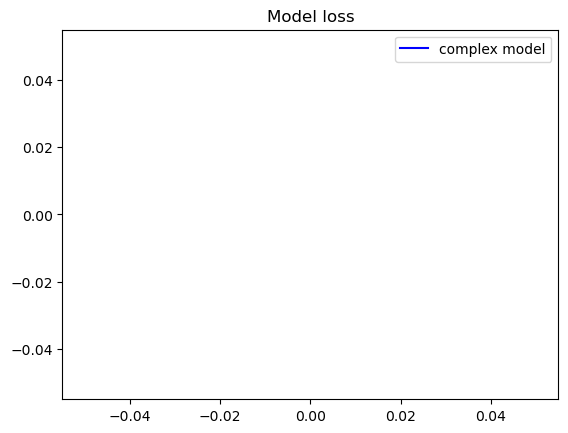

In [9]:
# Building and fitting of the model
model, encoder, decoder = train_model_complex(df, X_train, params=params)

In [10]:
#Load encoders
with open("./encoders/integer_encoder.pkl", "rb") as f: 
    integer_encoder = pickle.load(f)

with open("./encoders/v_gene_encoder.pkl", "rb") as f:
    v_gene_encoder = pickle.load(f)

with open("./encoders/j_gene_encoder.pkl", "rb") as f:
    j_gene_encoder = pickle.load(f)


In [11]:
# Encode and decode sequences to generate new sequences
N = 100000
df_test = df[:N]
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]
X_test_encode = encoder.predict(X_test[:N])
X_test_decode = decoder.predict(X_test_encode)

3125/3125 [==============================] - 1s 426us/step


In [12]:
# Round values to integers
X_test_decode = np.round(X_test_decode, 0)
X_test_decode = np.where(X_test_decode > 20, 20, X_test_decode)
X_test_decode = np.where(X_test_decode < 0, 0, X_test_decode)

# Convert to integers
X_test_decode = X_test_decode.astype(int)

In [13]:
# Transform integer encoded to letters using the loaded labelencoders
seqs = []
for i in range(len(X_test_decode)):
    seqs.append(integer_encoder.inverse_transform(X_test_decode[i, :]))
    seqs[i] = "".join(seqs[i])
    seqs[i] = seqs[i].replace("-", "")

In [14]:
# Save results as tsv for post-processing using OLGA
df_test[["CDR3"]].to_csv("./OLGA_Test/df_test_olga.tsv", sep="\t", index=False, header=False)

In [109]:
# Save as tsv
df_test_predict  = df_test.copy()
df_test_predict["CDR3"] = seqs
df_test_predict[["CDR3"]].to_csv("./OLGA_Test/df_test_predict_olga.tsv", sep="\t", index=False, header=False)

In [15]:
### RUN OLGA THROUGH THE COMMAND LINE ###

# Load results from OLGA
p_gens_predict = pd.read_csv("./OLGA_Test/df_test_predict_olga_pgens.tsv", sep="\t", header=None)

p_gens = pd.read_csv("./OLGA_Test/df_test_olga_pgens.tsv", sep="\t", header=None)


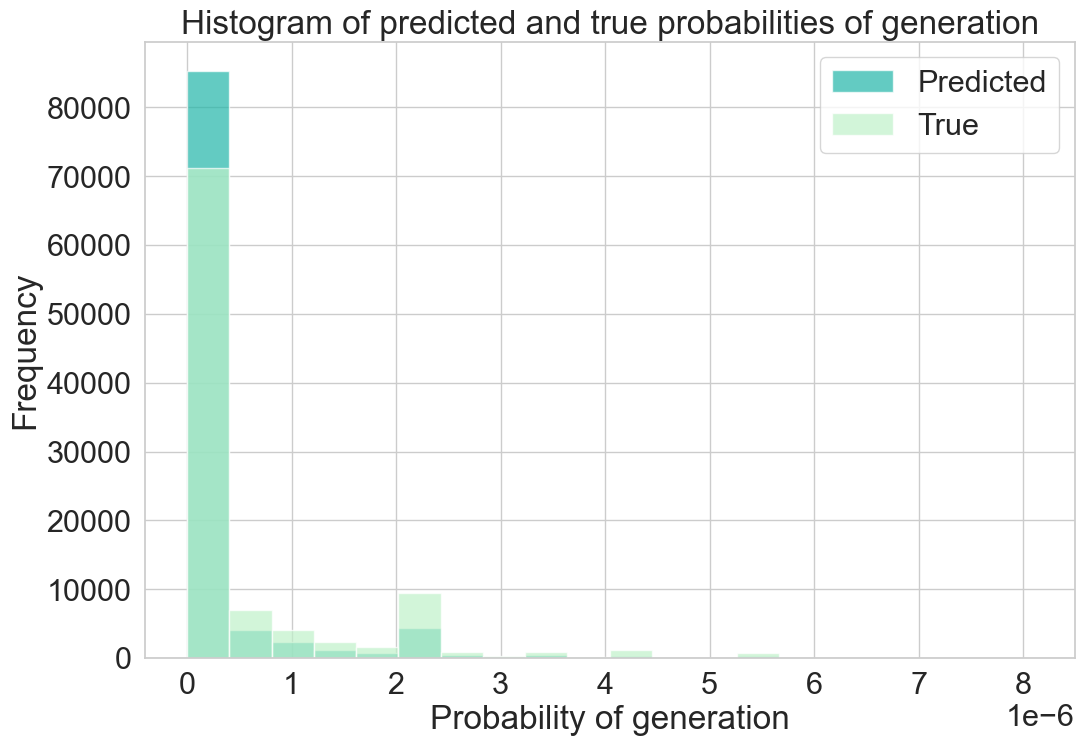

In [30]:
# Plot the histogram of the predicted and true p_gens 
sns.set(rc={'figure.figsize':(12,8)}, font_scale=2, style="whitegrid", palette="bright")
plt.figure(figsize=(12,8))
plt.hist(p_gens_predict[1], bins=20, alpha=0.7, label="Predicted", color="#21B6A8")
plt.hist(p_gens[1], bins=20, alpha=0.7, label="True", color="#c0f1ca")
plt.legend(loc="upper right")
plt.title("Histogram of predicted and true probabilities of generation")
plt.xlabel("Probability of generation")
plt.ylabel("Frequency")
plt.savefig("./images/p_gens_hist.png", dpi=300, bbox_inches='tight')
plt.show()


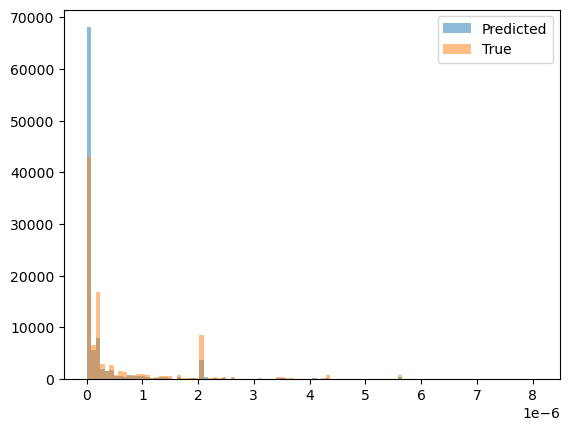

In [17]:
# Plot the histogram of the predicted and true p_gens 
plt.hist(p_gens_predict[1], bins=100, alpha=0.5, label="Predicted")
plt.hist(p_gens[1], bins=100, alpha=0.5, label="True")
plt.legend(loc="upper right")
plt.show()


In [18]:
# Filter the p_gens to detect outliers for more consistent analysis
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

filtered_predict = is_outlier(p_gens_predict[1])
filtered_predict = p_gens_predict[~filtered_predict]

filtered = is_outlier(p_gens[1])
filtered = p_gens[~filtered]

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_25712/4145419443.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


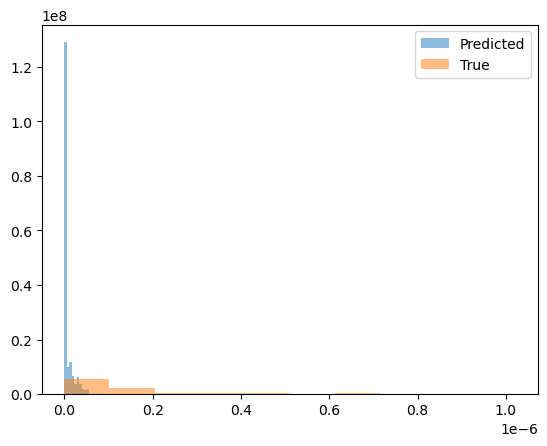

In [19]:
# Plot again the histogram of the predicted and true p_gens 
plt.hist(filtered_predict[1], bins=10, alpha=0.5, label="Predicted", density=True)
plt.hist(filtered[1], bins=10, alpha=0.5, label="True", density=True)
plt.legend(loc="upper right")
plt.show()
